# transformer-helpers.ipynb

> Code that helps run and inspect parts of the transformer model.

In [ ]:
#| default_exp models.transformer_helpers

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
from fastcore.test import *

In [ ]:
#| export
from dataclasses import dataclass
from typing import Dict, Iterable, Optional, Sequence, Tuple

In [ ]:
#| export
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In [ ]:
#| export
from transformer_experiments.models.transformer import (
    block_size,
    Block,
    n_head,
    n_embed,
    n_layer,
    TransformerLanguageModel
)
from transformer_experiments.tokenizers.char_tokenizer import CharacterTokenizer


In [ ]:
# Not exported because only used for testing within this notebook
from transformer_experiments.datasets.tinyshakespeare import (
    TinyShakespeareDataSet,
)
from transformer_experiments.trained_models.tinyshakespeare_transformer import (
    create_model_and_tokenizer
)

In [ ]:
# Create a model for testing
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device is {device}")

ts = TinyShakespeareDataSet(cache_file='../artifacts/input.txt')
m, tokenizer = create_model_and_tokenizer(
    saved_model_filename='../artifacts/shakespeare-20231109.pt',
    dataset=ts,
    device=device,
)

device is cpu


## Helper functions for encoding/decoding strings

In [ ]:
# | export
class EncodingHelpers:
    """Helper class that wraps a tokenizer and provides methods for encoding
    and decoding strings. The tokenizer just deals with regular Python types
    whereas this class deals with PyTorch tensors."""
    def __init__(
        self, tokenizer: CharacterTokenizer, device: str
    ):
        self.tokenizer = tokenizer
        self.device = device

    def tokenize_string(self, s: str) -> torch.Tensor:
        """Given a string, returns a tensor representing the tokenized string.
        The returned tensor has shape (1, T) where T is the number of tokens,
        so it works in situations that expect a batch dimension."""
        return self.tokenize_strings([s])

    def tokenize_strings(self, strings: Sequence[str]) -> torch.Tensor:
        """Given a sequence of strings, returns a tensor representing the
        tokenized strings. The returned tensor has shape (N, T) where N is the
        number of strings and T is the number of tokens, so it works in
        situations that expect a batch dimension."""
        return torch.tensor(
            [self.tokenizer.encode(s) for s in strings], dtype=torch.long, device=self.device
        )

    def stringify_tokens(self, tokens: torch.Tensor) -> str:
        """Given a tensor of tokens, returns a string representing the tokens."""
        return self.tokenizer.decode(tokens.tolist())



In [ ]:
# Tests for encoding helpers
encoding_helpers = EncodingHelpers(tokenizer, device)
tokenized = encoding_helpers.tokenize_string('hello')
test_eq(tokenized.shape, (1, 5))
test_eq(tokenized, torch.tensor([[46, 43, 50, 50, 53]]))

stringified = encoding_helpers.stringify_tokens(tokenized[0])
test_eq(stringified, 'hello')

tokenized = encoding_helpers.tokenize_strings(['hello', 'world'])
test_eq(tokenized.shape, (2, 5))

test_eq(tokenized, torch.tensor([[46, 43, 50, 50, 53], [61, 53, 56, 50, 42]]))

## Helpers for dealing with embeddings

In [ ]:
# | export
def unsqueeze_emb(
    emb: torch.Tensor, expected_last_dim_size: int=n_embed
) -> torch.Tensor:
    """A lot of things expect embedding tensors to have shape (B, T, X) where
    X is usually either n_embed or vocab_size. This function takes an embedding
    tensor that may be missing some of these dimensions and adds them as
    necessary."""
    ndim = emb.ndim
    if ndim > 3:
        raise ValueError(f"Expected embedding tensor to have ndim <= 3, got {ndim}")

    if emb.shape[-1] != expected_last_dim_size:
        raise ValueError(
            f"Expected embedding tensor to have last dimension {expected_last_dim_size}, got {emb.shape[-1]}"
        )

    if ndim == 1:
        return emb.unsqueeze(0).unsqueeze(0)
    elif ndim == 2:
        return emb.unsqueeze(0)

    return emb  # ndim == 3, nothing to change

In [ ]:
# Tests for unsqueeze_emb
emb = torch.randn(5) # Wrong last dimension
with ExceptionExpected(ex=ValueError):
    unsqueeze_emb(emb)

emb = torch.randn(n_embed) # missing B and T dimensions
emb = unsqueeze_emb(emb)
test_eq(emb.shape, (1, 1, n_embed))

emb = torch.randn(1, n_embed) # missing B dimension
emb = unsqueeze_emb(emb)
test_eq(emb.shape, (1, 1, n_embed))

emb = torch.randn(3, n_embed) # missing B dimension, T is 3
emb = unsqueeze_emb(emb)
test_eq(emb.shape, (1, 3, n_embed))

emb = torch.randn(2, 3, n_embed) # nothing to change
emb = unsqueeze_emb(emb)
test_eq(emb.shape, (2, 3, n_embed))

# custom expected value for last dim
emb = torch.randn(2, 3, 10) # nothing to change
emb = unsqueeze_emb(emb, expected_last_dim_size=10)
test_eq(emb.shape, (2, 3, 10))


## Helpers for Running Selective Parts of the Model
The functions in this section enable running pieces of the model in isolation and introspecting their intermediate results. This is useful for debugging and understanding the model.

In [ ]:
# | export
class InputOutputAccessor:
    def __init__(self, activations: Dict[str, Tuple]):
        self.activations = activations

    def inputs(self, name: str) -> Tuple[torch.Tensor]:
        return self.activations[name][0]

    def input(self, name: str) -> torch.Tensor:
        inps = self.inputs(name)
        assert len(inps) == 1
        return inps[0]

    def output(self, name: str) -> torch.Tensor:
        return self.activations[name][1]

In [ ]:
# | export
class TransformerAccessors:
    """Class that provides methods for running pieces of a `TransformerLanguageModel`
    in isolation and introspecting their intermediate results."""

    def __init__(self, m: TransformerLanguageModel, device: str):
        self.m = m
        self.device = device

    def embed_tokens(self, tokens: torch.Tensor) -> torch.Tensor:
        """Given a tensor containing a batch of tokens (shape B, T),
        performs the token and positional embeddings done at the beginning of
        the model and returns the tensor that would be sent into the stack of
        blocks."""
        idx = tokens[:, -block_size:]

        # Logic from the model's forward() function
        B, T = idx.shape
        token_emb = self.m.token_embedding_table(idx)
        pos_emb = self.m.position_embedding_table(
            torch.arange(T, device=self.device)
        )  # (T, n_embed)
        x = token_emb + pos_emb
        return x.detach()

    def copy_block_from_model(self, block_idx: int):
        """Given the index of a block in the model [0, n_layer), creates
        a new block with identical parameters.

        Returns
        -------
        Tuple
            First element is the new block, second is an `InputOutputAccessor` that
            provides access to the inputs and outputs of the block itself, it top-level
            sub-modules, and children of the self-attention sub-module.
        """
        block = self.m.blocks[block_idx]
        new_block = Block(n_embed, n_head)
        new_block.load_state_dict(block.state_dict())
        new_block.eval()

        activations = {}

        def log_activation_hook(name):
            def hook(_, input, output):
                inputs = tuple([inp.detach() for inp in input])
                activations[name] = (inputs, output.detach())

            return hook

        new_block.register_forward_hook(log_activation_hook('.'))
        for name, module in new_block.named_children():
            module.register_forward_hook(log_activation_hook(name))

        # Register the hook for the self-attention layer's children as
        # I will need this. Wanted this function to not have to know
        # about the internal structure of a block (i.e. not access members
        # by a specific name), so this is unfortunate, but the most expedient.
        for name, module in new_block.sa.named_children():
            module.register_forward_hook(log_activation_hook(f'sa.{name}'))

        return new_block, InputOutputAccessor(activations)

    def check_valid_input_shape(self, emb):
        if emb.ndim != 3:
            raise ValueError(
                f"Expected embedding tensor to have ndim 3, got {emb.ndim}"
            )

        if emb.shape[-1] != n_embed:
            raise ValueError(
                f"Expected embedding tensor to have last dimension {n_embed}, got {emb.shape[-1]}"
            )

    def logits_from_embedding(self, emb: torch.Tensor) -> torch.Tensor:
        """Given embeddings, returns the logits that would be
        generated by the model."""
        x = self.m.ln_f(emb)
        logits = self.m.lm_head(x)

        return logits.detach()

    def run_model(
        self, embedded_input: torch.Tensor
    ) -> Tuple[torch.Tensor, Sequence[InputOutputAccessor]]:
        """Given an input (already embedded), runs the model on it and returns a
        the logits and a sequence of `InputOutputAccessor` objects that provide
        access to the inputs and outputs of each block in the model."""
        self.check_valid_input_shape(embedded_input)

        blocks, io_accessors = zip(
            *[  # See https://stackoverflow.com/a/13635074
                self.copy_block_from_model(block_idx=i) for i in range(n_layer)
            ]
        )

        blocks_module = nn.Sequential(*blocks)

        x = blocks_module(embedded_input)
        logits = self.logits_from_embedding(x)

        return logits.detach(), io_accessors

In [ ]:
# Test embed tokens
encoding_helpers = EncodingHelpers(tokenizer, device)
s = 'hello'
tokenized = encoding_helpers.tokenize_string(s)

accessors = TransformerAccessors(m, device)
embedded_from_tokens = accessors.embed_tokens(tokenized)
test_eq(embedded_from_tokens.shape, (1, len(s), n_embed))

In [ ]:
# Test check_valid_input_shape
accessors = TransformerAccessors(m, device)
emb = torch.randn(5) # Wrong last dimension
with ExceptionExpected(ex=ValueError):
    accessors.check_valid_input_shape(emb)

emb = torch.randn(n_embed) # missing B and T dimensions
with ExceptionExpected(ex=ValueError):
    accessors.check_valid_input_shape(emb)

emb = torch.randn(1, n_embed) # missing B dimension
with ExceptionExpected(ex=ValueError):
    accessors.check_valid_input_shape(emb)

emb = torch.randn(3, n_embed) # missing B dimension, T is 3
with ExceptionExpected(ex=ValueError):
    accessors.check_valid_input_shape(emb)

emb = torch.randn(2, 3, n_embed) # all good
accessors.check_valid_input_shape(emb)

In [ ]:
# Test block copying
accessors = TransformerAccessors(m, device)
block_idx = 0
old_b = m.blocks[block_idx]
new_b, io_accessor = accessors.copy_block_from_model(block_idx)
test_eq(new_b is old_b, False)

encoding_helpers = EncodingHelpers(tokenizer, device)
tokens = encoding_helpers.tokenize_string('Citizen')
x = accessors.embed_tokens(tokens)
old_result = old_b(x).detach()
new_result = new_b(x).detach()
test_eq(old_result, new_result)
test_eq(io_accessor.input('.'), x)
test_eq(io_accessor.output('.'), new_result)

In [ ]:
# Test running the model
encoding_helpers = EncodingHelpers(tokenizer, device)
accessors = TransformerAccessors(m, device)

prompt = 'Citizen'
tokens = encoding_helpers.tokenize_string(prompt)
x = accessors.embed_tokens(tokens)
logits, io_accessors = accessors.run_model(x)

test_eq(len(io_accessors), n_layer)

# Run the model the normal way and make sure the logits are the same
orig_model_logits, _ = m(tokens)
test_eq(logits, orig_model_logits.detach())

## Helpers for dealing with Logits 

In [ ]:
# | export
class LogitsWrapper:
    """A wrapper class around a tensor of logits that provides
    convenience methods for interpreting and visualizing them."""

    def __init__(self, logits: torch.Tensor, tokenizer: CharacterTokenizer):
        # For consistency, we always want logits to be of shape (B, T, vocab_size).
        # It's up to the calling code to add the B and T dimensions if necessary.
        assert logits.dim() == 3
        _, _, vocab_size = logits.shape
        assert vocab_size == tokenizer.vocab_size

        self.logits = logits
        self.tokenizer = tokenizer

    def probs(self) -> torch.Tensor:
        return F.softmax(self.logits, dim=-1)

    def topk_tokens(self, k: int) -> Sequence[Sequence[Sequence[Tuple[str, float]]]]:
        """Returns the top k tokens and their probabilities."""
        probs = self.probs()
        _, topk_indices = torch.topk(probs, k=k, dim=-1)

        B, T, _ = self.logits.shape
        top_tokens = [
            [
                [
                    (self.tokenizer.itos[i], probs[b_i, t_i, i].item())
                    for i in topk_indices[b_i, t_i].tolist()
                ]
                for t_i in range(T)
            ]
            for b_i in range(B)
        ]

        return top_tokens

    def plot_probs(
        self,
        b_i: int = 0,
        t_i: int = -1,
        title: str = '',
        ax: Optional[Axes] = None,
        figsize=(12, 4),
    ):
        """Plots the output probabilities for each token based on the logits"""
        if ax is None:
            _, ax = plt.subplots(figsize=figsize)

        x_indices = np.arange(self.tokenizer.vocab_size)
        x_labels = [repr(c)[1:-1] for c in self.tokenizer.chars]

        ax.bar(x_indices, self.probs()[b_i, t_i])
        ax.set_xticks(x_indices, x_labels, rotation='vertical')
        ax.set_title(title)
        ax.set_ylim(0.0, 1.0)

In [ ]:
# Tests for LogitsWrapper

# Test that creating a LogitsWrapper from a tensor that doesn't have the B and T
# dimensions results in an assertion error.

logits = torch.randn(tokenizer.vocab_size) # (vocab_size,)
with ExceptionExpected(ex=AssertionError):
    LogitsWrapper(logits, tokenizer)

logits = torch.randn(2, tokenizer.vocab_size) # (2, vocab_size,) - missing B dimension
with ExceptionExpected(ex=AssertionError):
    LogitsWrapper(logits, tokenizer)

# Create a logits tensor where the tokens 'h' and 'm' have
# equally high values.
logits = torch.zeros(1, 1, tokenizer.vocab_size) # (1, 1, vocab_size)
logits[0, 0, tokenizer.stoi['h']] = 100
logits[0, 0, tokenizer.stoi['m']] = 100

# Create a logits wrapper
lw = LogitsWrapper(logits, tokenizer)

# Test that probs() returns the right things
probs = lw.probs()
test_eq(probs.shape, (1, 1, tokenizer.vocab_size))
test_close(probs[0, 0, tokenizer.stoi['h']], 0.5)
test_close(probs[0, 0, tokenizer.stoi['m']], 0.5)

# Test that topk_tokens returns the right things
topk = lw.topk_tokens(k=2)[0][0]
tokens, probs = zip(*topk)
test_eq(len(tokens), 2)
test_eq('h' in tokens, True)
test_eq('m' in tokens, True)
for p in probs:
    test_close(p, 0.5)


In [ ]:
# "Integration test" for logits_from_embedding() and LogitsWrapper. The values
# here will change if the model weights change but otherwise should be stable.
strings = ['Citizen', 'ANTONIO']

tokens_batch = torch.tensor(
    [tokenizer.encode(s) for s in strings], dtype=torch.long, device=device
)

accessors = TransformerAccessors(m, device)

embedded = accessors.embed_tokens(tokens_batch)

logits = accessors.logits_from_embedding(embedded)
lw = LogitsWrapper(logits, tokenizer)

expected_top_tokens = ['!', 'z', 'a', 'e', '\'']
topk = lw.topk_tokens(k=5)[0][-1]
tokens, probs = zip(*topk)
test_eq(tokens, expected_top_tokens)
expected_probs = [
    0.08952,
    0.08505,
    0.08317,
    0.04933,
    0.04017,
]
for i, p in enumerate(probs):
    test_close(p, expected_probs[i], eps=1e-5)



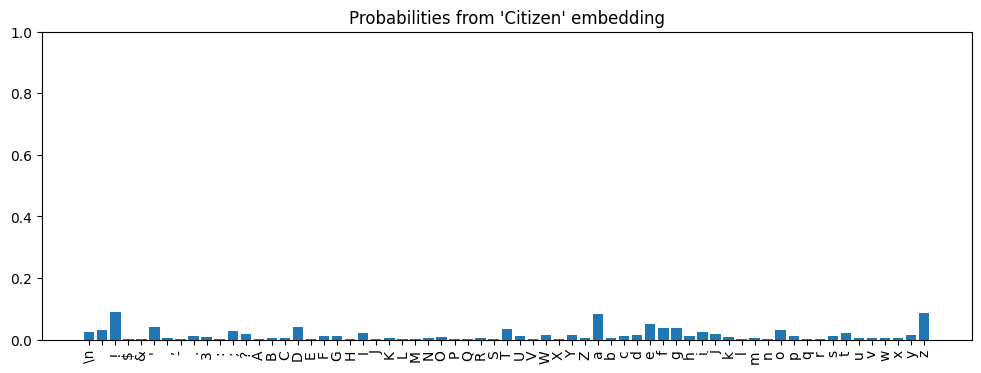

In [ ]:
# Make a plot - part of the "integration test" above
b_i = 0
lw.plot_probs(b_i=0, t_i=-1, title=f"Probabilities from {repr(strings[b_i])} embedding")

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()